* Họ và tên : Nguyễn Trọng Đạt
* MSSV : 19021240
* Lớp : INT3405E_20

# 1. Mô tả bài toán

## Giới thiệu bài toán
1. Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi và kết nối với những người khác, những người đóng góp thông tin chi tiết độc đáo và câu trả lời chất lượng.
2. Một vấn đề tồn tại đối với bất kỳ trang web lớn nào hiện nay là làm thế nào để xử lý nội dung độc hại và gây chia rẽ.
3. Quora muốn giải quyết vấn đề này trực tiếp để giữ cho nền tảng của họ trở thành một nơi mà người dùng có thể cảm thấy an toàn khi chia sẻ kiến thức của họ với thế giới.
4. Một thách thức quan trọng là loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích.
5. Trong notebook này, đề xuất phát triển các mô hình xác định và gắn cờ cho các "insincere questions"


### Thêm các thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import random
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud,STOPWORDS
import re
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer

### Tham số 

In [2]:
embedding_dim = 300 # how big is each word vector
vocab_size = 150000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use
# Decide which device we want to run on
tagset_size = 1
batch_size=512
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

### Đảm bảo tính xác định
Vì ở phần sau, em dùng mô hình train trên GPU nên sẽ thiếu tính "determinism" sau mỗi lần train. Có thể hiểu nôm na rằng sau 2 lần train với cùng một bộ dữ liệu, chúng ta sẽ có 2 mô hình không hoàn toàn giống nhau, một cái tốt hơn và một cái cho ra kết quả tệ hơn. \
Mặc dù sự sai khác của 2 mô hình này là không nhiều nhưng để ổn định hơn, em sẽ xử lý nó bằng cách sử dụng "seed". Seed là một điểm bắt đầu trong một chuỗi xác định, nó đảm bảo rằng khi ta dùng cùng một seed, kết quả cho ra qua các lần chạy đều giống nhau

In [3]:
def set_seed(seed_value=2022):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
set_seed()

# 2. Phân tích dữ liệu


## 2.1 Khảo sát dữ liệu


### 2.1.1Đọc dữ liệu

In [4]:
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

### 2.1.2 Tổng quan về dữ liệu

In [5]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
train_df.tail()

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


Bộ dữ liệu có 3 cột là **qid** - id của câu hỏi, **question_text** - nội dung của câu hỏi và **target** - phân loại câu hỏi bằng hai giá trị là 0, 1 với 0 là các câu hỏi "**sincere**" và 1 là các câu hỏi "**insincere**"

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


Bộ dữ liệu có 1306122 câu hỏi \
Các câu hỏi "sincere"

In [8]:
train_df[train_df['target']==0].head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Các câu hỏi "insincere"

In [9]:
train_df[train_df['target']==1].head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


## 2.2 Visualize data


### 2.2.1 Thống kê về dữ liệu

In [10]:
labels = collections.Counter(train_df['target']).keys()
amounts = collections.Counter(train_df['target']).values()
labels, amounts

(dict_keys([0, 1]), dict_values([1225312, 80810]))

(80810, 3) (1225312, 3)
--------------------------


<AxesSubplot:xlabel='target', ylabel='count'>

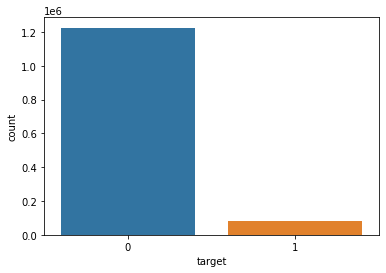

In [11]:
insincere_data_train = train_df[train_df.target == 1]
sincere_data_train = train_df[train_df.target == 0]
print(insincere_data_train.shape, sincere_data_train.shape)
print("--------------------------")

sns.countplot(x='target', data=train_df)

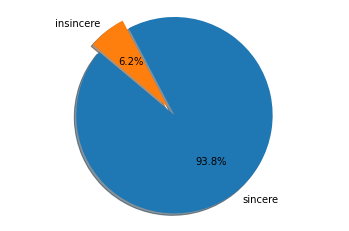

In [12]:
sincere_percent= (len(train_df.question_text[train_df['target'] == 0]) /  len(train_df['question_text']) * 100)
insincere_percent= (len(train_df.question_text[train_df['target'] == 1]) / len(train_df['question_text']) * 100)
__labels = 'sincere', 'insincere'
sizes = [sincere_percent, insincere_percent]
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=__labels,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Nhận thấy **"sincere question"** có hơn 1,2 triệu câu hỏi, chiếm 93.8% tập train, còn lại 6.2% cho **"insincere question"** với khoảng gần 81,000 câu hỏi. Nhận thấy lượng data có sự chênh lệnh lớn khi số lượng **"sincere question"** gấp 15 lần so với **"insincere question"**. Với lượng data bị mất cân bằng giữa các nhãn như thế này, chúng ta cần phải có một biện pháp khắc phục sự mất cân bằng để mô hình cho được kết quả tốt nhất.

### 2.2.1 Phân tích câu trong data
Thống kê số kí tự trong từng câu

<AxesSubplot:>

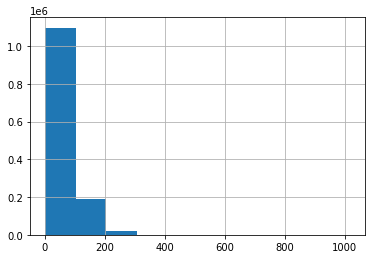

In [13]:
train_df['question_text'].str.len().hist()

Số lượng từ có trong 1 câu

<AxesSubplot:>

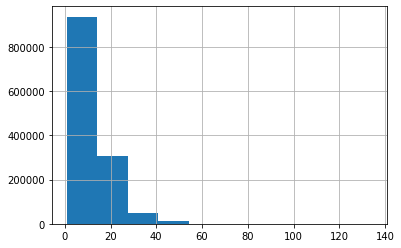

In [14]:
train_df['question_text'].str.split().map(lambda x: len(x)).hist()

Chúng ta có thể thấy độ dài các từ trong khoảng 0-20 chiếm phần đa dữ liệu . Max độ dài từ cũng chỉ là 70. Từ đó chúng ta chọn chiều dài biểu diễn vecto trong câu là 70\
maxlen = 70 # max number of words in a question to use

#### Chúng ta cùng xem qua các từ xuất hiện nhiều nhất trong các câu hỏi của dữ liệu


[Text(0.5, 1.0, 'Các từ xuất hiện nhiều nhất trong dữ liệu Train')]

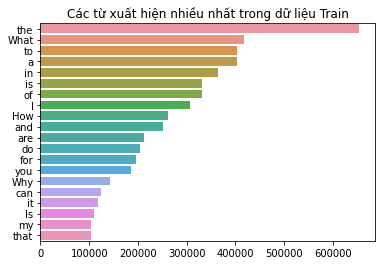

In [15]:
new_corpus = []
quest = train_df['question_text'].str.split()
quest = quest.values.tolist()
new_corpus = [word for q in quest for word in q]
counter = collections.Counter(new_corpus)
most = counter.most_common()

x,y= [],[]
for word,count in most[:20]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x).set(title='Các từ xuất hiện nhiều nhất trong dữ liệu Train')

[Text(0.5, 1.0, 'Các từ xuất hiện nhiều nhất trong dữ liệu Test')]

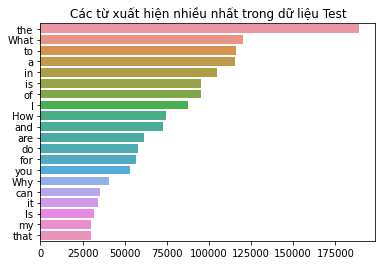

In [16]:
new_corpus = []
quest = test_df['question_text'].str.split()
quest = quest.values.tolist()
new_corpus = [word for q in quest for word in q]
counter = collections.Counter(new_corpus)
most = counter.most_common()

x,y= [],[]
for word,count in most[:20]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x).set(title='Các từ xuất hiện nhiều nhất trong dữ liệu Test')

#### Xem các cụm từ xuất hiện nhiều trong các câu hỏi

In [17]:
def bigrams_data(data):
    bigrams = []
    for question in data:
        question = [w for w in question.lower().split() if w not in STOPWORDS] # không lấy các từ stopword
        if not question: 
            continue # tránh việc mảng question rỗng gây ra lỗi khi dùng nltk.bigrmas
        bi = [b for b in nltk.bigrams(question)]
        bi = [' '.join(w) for w in bi]
        bigrams.extend(bi)
    return bigrams

def draw_plt(data, title, bar_color, numberOfWordsInTop):
    top_words = collections.Counter(data).most_common(numberOfWordsInTop) # 25 từ xuất hiện nhiều nhất

    df_top = pd.DataFrame(top_words, columns=['word', 'count']).sort_values('count')

    plt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=bar_color)
    plt.title(f'Top words in {title}')

bigrams_sincere = bigrams_data(train_df[train_df['target']==0]['question_text'])
bigrams_insincere = bigrams_data(train_df[train_df['target']==1]['question_text'])

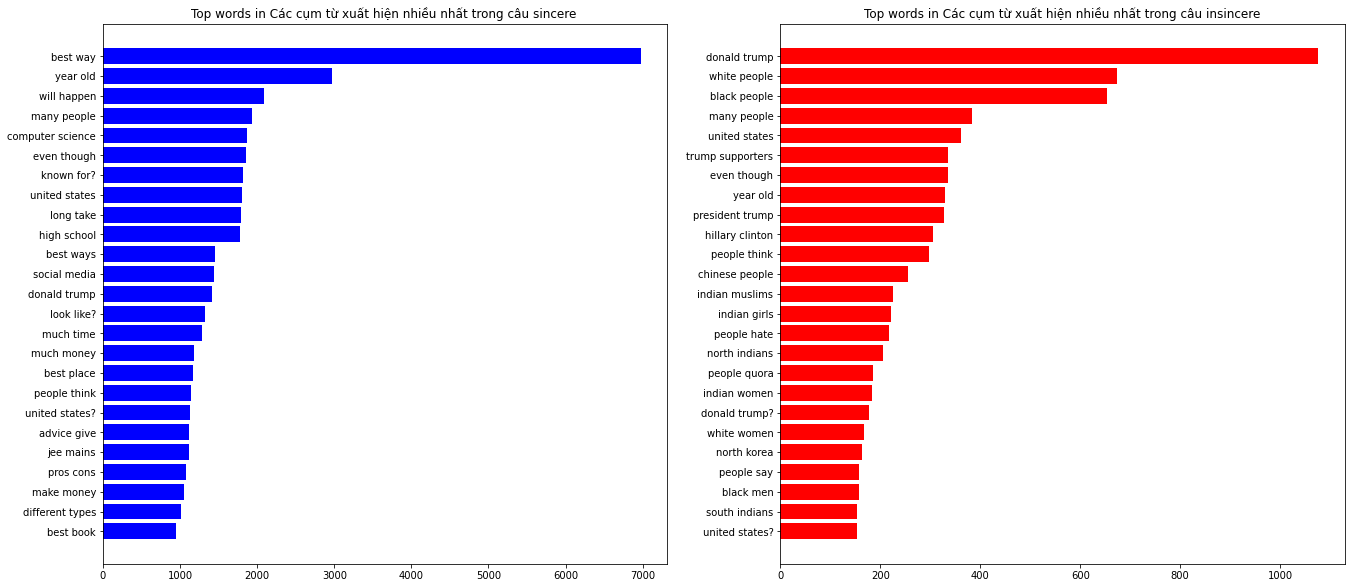

In [18]:
plt.subplot(1, 2, 1)
draw_plt(bigrams_sincere, 'Các cụm từ xuất hiện nhiều nhất trong câu sincere ', 'blue',25)


plt.subplot(1, 2, 2)
draw_plt(bigrams_insincere, 'Các cụm từ xuất hiện nhiều nhất trong câu insincere', 'red',25)

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

#### Khảo sát các từ xuất hiện nhiều trong các câu hỏi
Biểu đồ word cloud

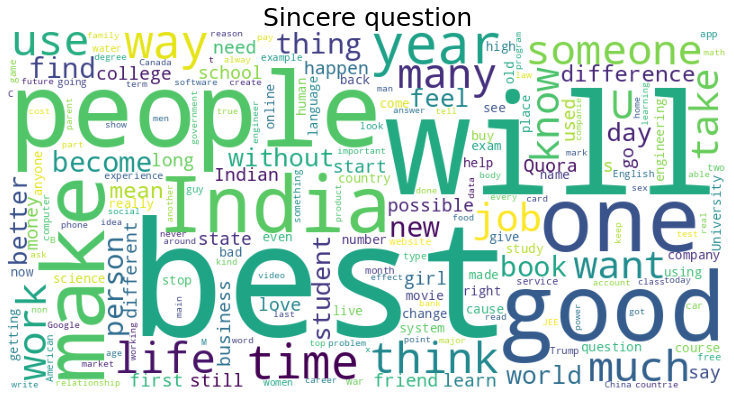

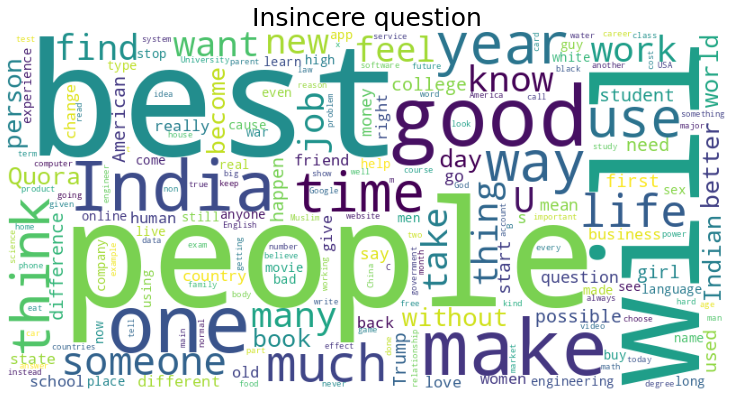

In [19]:
def cloud(docs, title):
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color="white").generate(" ".join(docs))
    fig = plt.figure(figsize=(10,7), facecolor='w')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=25,color='k')
    plt.tight_layout(pad=0)
    plt.show()
cloud(train_df[train_df['target']==0]['question_text'], "Sincere question")
cloud(test_df['question_text'][train_df['target']==1], "Insincere question")

## 2.3 Tiền xử lý dữ liệu
Tham khảo tại : https://www.kaggle.com/sunnymarkliu/more-text-cleaning-to-increase-word-coverage


### 2.3.1 Làm sạch dữ liệu
**clean_text** :xử lý các ký tự đặc biệt tồn tại trong văn bản đầu vào, các ký tự đặc biệt được lấy từ mảng puncts bên dưới. Hiểu đơn giản là bỏ đi các ký tự đặc biệt và xóa dấu câu\
**clean_number** : Xử lý các chữ số đầu vào, thay thế bằng các ký tự #s tại vì các thư viện embedding đã xử lý các số theo cách này\
**replace_typical_misspell**: xử lý các từ viết tắt trong câu đầu vào bằng **mispell_dict** tương ứng

In [20]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2",
                 "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '”': '"', '“': '"', "£": "e",
                 '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta',
                 '∅': '', '³': '3', 'π': 'pi', '\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
for p in puncts:
    punct_mapping[p] = ' %s ' % p

p = re.compile('(\[ math \]).+(\[ / math \])')
p_space = re.compile(r'[^\x20-\x7e]')

#Remove stop word
def remove_stopwords(text):
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    return text

def clean_text(text):
    # clean latex maths
    text = p.sub(' [ math ] ', text)
    # clean invisible chars
    text = p_space.sub(r'', text)
    # clean punctuations
    for punct in punct_mapping:
        if punct in text:
            text = text.replace(punct, punct_mapping[punct])
    #Remove stop word
#     text = remove_stopwords(text)
    return text

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will", "i'll've": "I will have", "i'm": "i am",
                "i've": "I have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
                "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is",
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                "they'll've": "they will have", "they're": "they are", "they've": "they have",
                "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
                'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize',
                'youtu ': 'youtube ', 'qoura': 'quora', 'sallary': 'salary', 'whta': 'what',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doi': 'do I',
                'thebest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation',
                'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis',
                'etherium': 'ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017',
                '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess',
                "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
#Removing Contractions
def replace_typical_misspell(text):
    tokens = []
    for token in text.split():
        # replace contractions & correct misspells
        token = mispell_dict.get(token.lower(), token)
        tokens.append(token)
    text = ' '.join(tokens)
    return text
    
#Remove contraction
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_map[t] if t in contraction_map else t for t in text.split(" ")])
    return text
    

### 2.3.2 Chuẩn hoá dữ liệu
1. Chuyển hết tất cả các ký tự trong câu hỏi về dạng viết thường
2. Xử các ký tự đặc biệt khỏi từng câu
3. Xử lý các chữ số nằm trong từng câu hỏi
4. Thay thế các từ viết tắt thành dạng nguyên bản của chúng
5. Thay thế các giá trị null trong cột questiontext bằng giá trị
6. Thêm một số trường dữ liệu cho dataset
7. Tokenize train data và test data : Chuyển text -> ma trận từ

<img src = "https://miro.medium.com/max/4800/0*c1o1ff1yupRvTLkY.png" width="400" height="400">\


8. Padding data : Các mô hình yêu cầu cùng kích thước đầu vào -> Lấp đầy những câu có ít từ (ma trận ngắn)






<img src = "https://miro.medium.com/max/1332/0*KL-8g0HlN6tnlMDk.png" width="400" height="400">

9. Shuffle data: trộn data ngẫu nhiên



In [21]:
from sklearn.preprocessing import StandardScaler
tqdm.pandas()
# Add features
def add_features(df):
    
    df['question_text'] = df['question_text'].progress_apply(lambda x:str(x))
    df['total_length'] = df['question_text'].progress_apply(len)
    df['capitals'] = df['question_text'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  

    return df

def load_and_prec():
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    
    # Lower
    train_df["question_text"] = train_df["question_text"].apply(lambda x: x.lower())
    test_df["question_text"] = test_df["question_text"].apply(lambda x: x.lower())

    # Clean the text
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    # Clean numbers
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_numbers(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_numbers(x))
    
    # Clean speelings
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: replace_typical_misspell(x))
    
    # Fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values
    ###################### Add Features ###############################
    train = add_features(train_df)
    test = add_features(test_df)
    
    features = train[['caps_vs_length', 'words_vs_unique']].fillna(0)
    test_features = test[['caps_vs_length', 'words_vs_unique']].fillna(0)

    ss = StandardScaler()
    ss.fit(np.vstack((features, test_features)))
    features = ss.transform(features)
    test_features = ss.transform(test_features)
    ###########################################################################

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    

    #shuffling the data
    np.random.seed(2022)
    trn_idx = np.random.permutation(len(train_X))

    train_X = train_X[trn_idx]
    train_y = train_y[trn_idx]
    features = features[trn_idx]
    
    return train_X, test_X, train_y, features, test_features, tokenizer.word_index

In [22]:
x_train, x_test, y_train,features, test_features, word_index = load_and_prec() 

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

In [23]:
x_train

array([[   0,    0,    0, ...,   10,  315,   39],
       [   0,    0,    0, ...,  121,   18, 2420],
       [   0,    0,    0, ...,  134,   13, 4041],
       ...,
       [   0,    0,    0, ..., 7922,  198, 8424],
       [   0,    0,    0, ...,  742,  179,  143],
       [   0,    0,    0, ...,  242, 6275, 1476]], dtype=int32)

### 2.3.3 Embedding
<img src = "https://miro.medium.com/max/1400/0*rAgNKeRR6Dm_PR0b.png" width="800" height="800">
Trong notebook này em sử dụng 3 thư viện embedding từ có sẵn của Google-glove, Facebook-fasttext, paragram
Tham khảo : https://www.kaggle.com/suicaokhoailang/blending-with-linear-regression-0-688-lb/notebook

In [24]:
!unzip ../input/quora-insincere-questions-classification/embeddings.zip

Archive:  ../input/quora-insincere-questions-classification/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [25]:
def load_glove(word_index):
    EMBEDDING_FILE = './glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(vocab_size, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in tqdm(word_index.items()):
        if i >= vocab_size: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = './wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    # word_index = tokenizer.word_index
    nb_words = min(vocab_size, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in tqdm(word_index.items()):
        if i >= vocab_size: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = './paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(vocab_size, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in tqdm(word_index.items()):
        if i >= vocab_size: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [26]:
set_seed()
embedding_matrix_1 = load_glove(word_index)
embedding_matrix_2 = load_fasttext(word_index)
embedding_matrix_3 = load_para(word_index)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


  0%|          | 0/184096 [00:00<?, ?it/s]

  0%|          | 0/184096 [00:00<?, ?it/s]

  0%|          | 0/184096 [00:00<?, ?it/s]

Xoá đi các dữ liệu đã giải nén trên ổ cứng

In [27]:
!rm -r ./glove.840B.300d
!rm -r ./GoogleNews-vectors-negative300
!rm -r ./wiki-news-300d-1M
!rm -r ./paragram_300_sl999

In [28]:
embedding_matrix = np.mean([embedding_matrix_1, embedding_matrix_2, embedding_matrix_3], axis=0)
np.shape(embedding_matrix)

(150000, 300)

In [29]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset[index]

        return data, target, index
    def __len__(self):
        return len(self.dataset)

# 3. Mô hình



## 3.1 Cross Validation
Vấn đề : Bộ dataset chúng ta chỉ có 2 tập, train và test, không có tập val. Chúng ta cũng không được dùng tập train để kiểm thử mô hình, vì nó sẽ dẫn tới overfitting trên tập train. Vậy chúng ta sẽ lấy 1 phần của tập train ra làm tập validation. Nhưng, tập train của dữ liệu quá ít nhãn 1, việc lấy ra 1 phần của tập lỡ như hầu hết nhãn 1 đều nằm trong tập val này thì dữ liệu nhãn 1 ở tập train sẽ ít đi và dẫn đến thiếu dữ liệu train. Điều này dẫn đến mô hình không học được nhãn 1, có thể model không tốt . Để mô hình được huấn luyện tốt nhất, em đề xuất sử dụng Cross Validation.
* Cross Validation là phương pháp chia nhỏ tập training ra thành N phần. Với mỗi lần train, mô hình sẽ sử dụng N-1 phần để train, sau đó test dựa trên 1 phần còn lại. Điều này sẽ giúp cho mô hình hạn chế gặp phải overfitting và giúp bạn tìm ra được những Hyper parameter tốt hơn.
<img src = "https://orig00.deviantart.net/fa87/f/2018/096/f/f/cross_validation_by_toiyeumayhoc-dc81ul7.png" width="800" height="800">

* Như hình chúng ta có thể thấy : Với mỗi lần train đầu, lấy 4 fold đầu tiên để train. Sau đó để val, sử dụng fold 5 để val. Qua lần train thứ 2, bạn lấy từ fold 2 đến fold 5 để train, rồi lại lấy fold 1 để val. Và đó, chính là Cross Validation.
<img src = "https://img00.deviantart.net/951a/i/2018/096/0/a/cross_validation_1_by_toiyeumayhoc-dc81vuz.jpg" width="600" height="600">

* Phương pháp đánh giá : Training data ta chia thành K phần. Sau đó train model K lần, mỗi lần train sẽ chọn 1 phần làm dữ liệu validation và K-1 phần còn lại làm dữ liệu training. Kết quả đánh giá model cuối cùng là trung bình cộng kết quả đánh giá của K lần train.

Em chia dữ liệu thành 5 phần:

In [30]:
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=2022).split(x_train, y_train))

## 3.2 Model CNN

Tham khảo tại : https://arxiv.org/abs/1408.5882

<img src="https://miro.medium.com/max/1400/0*0efgxnFIaLTZ2qkY" width="500" height="500">
Giải thích mô hình :
Đối với ảnh: Chúng ta thường sử dụng các max pooling các điểm ảnh lại với nhau( thường là các ô vuông) ví dụ  9*9 → 4*4. Tức chúng ta kéo các điểm ảnh lại gần hơn để trích xuất đặc trưng tương ứng của vùng ảnh đó. Nhưng đối với text chúng ta không làm như vậy được

Ở đây í tưởng chính của tác giả : Cố gắng học đặc trưng của 1-2-4-8 từ liền kề nhau trong câu, tại vì trong văn bản, các từ thường có quan hệ mật thiết với nhau và từ những đặc trưng đó sẽ phân lớp văn bản. 

Giả sử như hình vẽ trên :

Đầu vào của mô hình là 7 tokens , mỗi token có kích thước vecto embedding là 5 chiều. Kích thước ma trận input là : $7 \times 5$(giống như ma trận ảnh)

Ta có đầu vào : $\mathbf x_{emd} \in \mathbb R^{7\times5}$

Sau đó đầu vào sẽ đi qua một lớp tính chập (1-dimesional convolution) để trích xuất các đặc điểm từ câu. Ví dụ trên, chúng ta có tổng 6 filter, mỗi filter có shape$(f_i,d)$ trong đó $f_i$ là filter size for $i \in \{{1, 2, ..., 6}\}$. Sau đó mỗi filter sẽ scan qua $x_{emd}$ và trả về a feature map:
$$
\mathbf x_{conv_i} = ConV1D(\mathbf x_{emb}) \in \mathbb R^{N-f_i+1}
$$

Tiếp theo dùng hàm kích hoạt ReLU cho $\mathbf x_{conv_i}$ và sử dụng max-over-time-pooling để giảm mỗi feature map to a single scalar. Sau đó chúng ta nối các scalars thành một vecto. Sau đó chúng ta sẽ cho vec tơ này đi qua 1 bộ phân lớp MLP để cho ra output cuối cùng.

$$
\mathbf x_{pool_i} = MaxPool(ReLU(\mathbf x_{conv_i})) \in \mathbb R
$$

$$
\mathbf x_{fc} = concat(\mathbf x_{pool_i}) \in R^{6=size filter}
$$

Cuối cùng, chúng ta cho qua một lớp MLP có ma trận trọng số $\mathbb W_{fc} \in \mathbb R^{2 \times 6}$

$$
logits = Dropout(\mathbb W_{fc} \mathbf x_{fc}) \in \mathbb R^2
$$

Giải thích code : 

Ở đây e dùng luôn lớp tích chập 2D nhằm tối ưu tốc độ tính toán.

 num_filters e sử dụng là 36

filter_sizes = [1,2,3,5] chúng ta đang xem xét context window( đặc trưng) của 1,2,3,5 từ liên tiếp trong câu. Các cửa sổ filter sẽ dịch từ trên xuống dưới để học các đặc trưng này qua từng lớp tích chập Conv2d.



Tham khảo : 

In [31]:
hidden_size = 64

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        filter_sizes = [1,2,3,5]
        num_filters = 36
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embedding_dim)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, 1)

#     
    def forward(self, x):
        
        embeds = self.embedding(x)
        x = embeds.unsqueeze(1)  
        x = [nn.functional.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        out = self.fc1(x)
        return out

In [32]:
# matrix for the out-of-fold predictions
train_preds = np.zeros((len(x_train)))
# matrix for the predictions on the test set
test_preds = np.zeros((len(test_df)))

# always call this before training for deterministic results
# seed_everything()

x_test_cuda = torch.tensor(x_test, dtype=torch.long).to(device)
test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

avg_losses_f = []
avg_val_losses_f = []
train_loss = []
valid_loss = []

# Tracking best validation accuracy
best_accuracy = 0

## 3.3 Optimizers

In [33]:
base_lr, max_lr = 0.001, 0.003
def optimizers(model):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=max_lr)
    return optimizer

## 3.4 Loss Function

In [34]:
# define binary cross entropy loss
# note that the model returns logit to take advantage of the log-sum-exp trick 
# for numerical stability in the loss
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')

# 4. Training

## 4.1 Create PyTorch DataLoader

In [35]:
def create_data_loader(x_train,y_train,train_idx, valid_idx,batch_size):
    # split data in train / validation according to the KFold indeces
    # also, convert them to a torch tensor and store them on the GPU (done with .cuda())
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    
    x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.long).to(device)
    y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).to(device)
    
    x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.long).to(device)
    y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).to(device)
    
    #############################################################################################
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train = MyDataset(train)
    valid = MyDataset(valid)
    
    ##No need to shuffle the data again here. Shuffling happens when splitting for kfolds.
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader,valid_loader

## 4.2 Evaluate model

In [36]:
#eval model
def evaluate(model, valid_loader):
    
    # set evaluation mode of the model. This disabled operations which are only applied during training like dropout
    model.eval()
    # predict all the samples in y_val_fold batch per batch
    valid_preds_fold = np.zeros(len(valid_idx))
    avg_val_loss = 0
    val_accuracy = []
    
    for i, (x_batch, y_batch, index) in enumerate(valid_loader):
        
        with torch.no_grad():
            y_pred = model(x_batch).detach()
        
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        valid_preds_fold[i * batch_size:(i+1) * batch_size] = torch.special.expit(y_pred).cpu().numpy()[:, 0]
        if i==0 and epoch == 0:
            valid_loss.append(loss_fn(y_pred, y_batch))
        train_preds[valid_idx] = valid_preds_fold
        # Get the predictions
        preds = torch.argmax(y_pred, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == y_batch).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    
    print('val_accuracy = {:.4f} '.format(accuracy))
    return valid_preds_fold, avg_val_loss
#predicts model
def predict(model, test_loader):
    # predict all samples in the test set batch per batch
    test_preds_fold = np.zeros((len(test_df)))
    for i, (x_batch,) in enumerate(test_loader):
        
        y_pred = model(x_batch).detach()
        test_preds_fold[i * batch_size:(i+1) * batch_size] = torch.special.expit(y_pred).cpu().numpy()[:, 0]
    return test_preds_fold

## 4.2 Training

In [37]:
n_epochs = 4
set_seed()
for i, (train_idx, valid_idx) in enumerate(splits):
    train_loader,valid_loader = create_data_loader(x_train,y_train,train_idx, valid_idx,batch_size)
    model = CNN()

    # make sure everything in the model is running on the GPU
    model.to(device)
    
    optimizer = optimizers(model)
    print(f'Fold {i + 1}')
    for epoch in range(n_epochs):
        # =======================================
        #               Training
        # =======================================
        start_time = time.time()
        # set train mode of the model. This enables operations which are only applied during training like dropout
        
        model.train()
        avg_loss = 0.  
        for i, (x_batch, y_batch, index) in enumerate(train_loader):
            
            # Forward pass: compute predicted y by passing x to the model.           
            y_pred = model(x_batch)
            
            # Compute and print loss.
            loss = loss_fn(y_pred, y_batch)

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the Tensors it will update (which are the learnable weights
            # of the model)
            optimizer.zero_grad()
             # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
            avg_loss += loss.item()
            if(epoch==0 and i==0):
                train_loss.append(loss.item())
        
        # Calculate the average loss over the entire training data        
        avg_loss = avg_loss / len(train_loader)    
        
        
        # =======================================
        #               Evaluation
        # =======================================
        if valid_loader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            valid_preds_fold, avg_val_loss = evaluate(model, valid_loader)
            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t avg_loss={:.4f} \t avg_val_loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
        
        
    avg_losses_f.append(avg_loss)
    avg_val_losses_f.append(avg_val_loss) 
    #predics test_data_loader
    test_preds_fold = predict(model, test_loader)
    test_preds += test_preds_fold / len(splits)
    
    ##predics train_data_loader
    train_preds[valid_idx] = valid_preds_fold

print('All \t loss={:.4f} \t val_loss={:.4f} \t '.format(np.average(avg_losses_f),np.average(avg_val_losses_f)))

Fold 1
val_accuracy = 89.5238 
Epoch 1/4 	 avg_loss=60.8930 	 avg_val_loss=56.3061 	 time=274.11s
val_accuracy = 89.5238 
Epoch 2/4 	 avg_loss=55.5890 	 avg_val_loss=56.4961 	 time=269.03s
val_accuracy = 89.5238 
Epoch 3/4 	 avg_loss=53.1265 	 avg_val_loss=53.7339 	 time=268.42s
val_accuracy = 89.5238 
Epoch 4/4 	 avg_loss=51.1961 	 avg_val_loss=54.2262 	 time=269.12s
Fold 2
val_accuracy = 95.2381 
Epoch 1/4 	 avg_loss=61.2907 	 avg_val_loss=56.0876 	 time=270.12s
val_accuracy = 95.2381 
Epoch 2/4 	 avg_loss=55.7252 	 avg_val_loss=57.1018 	 time=269.33s
val_accuracy = 95.2381 
Epoch 3/4 	 avg_loss=53.5332 	 avg_val_loss=54.9824 	 time=270.12s
val_accuracy = 95.2381 
Epoch 4/4 	 avg_loss=51.4787 	 avg_val_loss=57.6308 	 time=269.90s
Fold 3
val_accuracy = 95.1923 
Epoch 1/4 	 avg_loss=60.9453 	 avg_val_loss=55.9222 	 time=268.75s
val_accuracy = 95.1923 
Epoch 2/4 	 avg_loss=55.5396 	 avg_val_loss=54.8946 	 time=269.38s
val_accuracy = 95.1923 
Epoch 3/4 	 avg_loss=53.0910 	 avg_val_loss=5

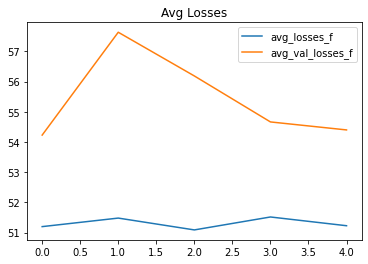

In [38]:
fig, ax = plt.subplots()
avg_losses_f_n=np.array(avg_losses_f)
avg_val_losses_f_n=np.array(avg_val_losses_f)
plt.plot(avg_losses_f_n, label='avg_losses_f')
plt.plot(avg_val_losses_f_n, label='avg_val_losses_f')
plt.title("Avg Losses")
plt.legend()

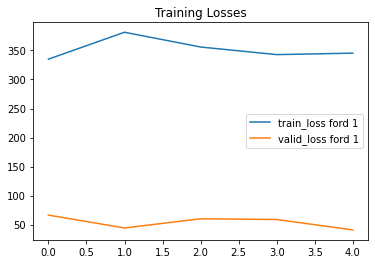

In [39]:
fig, ax = plt.subplots()
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)
plt.plot(train_loss, label='train_loss ford 1')
plt.plot(valid_loss, label='valid_loss ford 1')
plt.title("Training Losses")
plt.legend()

In [40]:
def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.501, 0.01)):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta
delta = bestThresshold(y_train,train_preds)

  0%|          | 0/41 [00:00<?, ?it/s]

best threshold is 0.2700 with F1 score: 0.6521


In [41]:
y_train_test = y_train
train_preds
train_preds_test = (train_preds > delta).astype(int)

unique, counts = np.unique(train_preds_test, return_counts=True)
dict(zip(unique, counts))
# np.amax(train_preds_test)


{0: 1212667, 1: 93455}

In [42]:
print(classification_report(y_train_test, train_preds_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98   1225312
           1       0.61      0.70      0.65     80810

    accuracy                           0.95   1306122
   macro avg       0.79      0.84      0.81   1306122
weighted avg       0.96      0.95      0.96   1306122



In [43]:
print(confusion_matrix(y_train_test, train_preds_test))

[[1188674   36638]
 [  23993   56817]]


In [44]:
submission = test_df[['qid']].copy()
submission['prediction'] = (test_preds > delta).astype(int)
submission.to_csv('submission.csv', index=False)

In [45]:
!head submission.csv

qid,prediction
0000163e3ea7c7a74cd7,1
00002bd4fb5d505b9161,0
00007756b4a147d2b0b3,0
000086e4b7e1c7146103,0
0000c4c3fbe8785a3090,0
000101884c19f3515c1a,0
00010f62537781f44a47,0
00012afbd27452239059,0
00014894849d00ba98a9,0
